# Deploying Gliders Project

###  The purpose of this code is to simulate the trajectories of gliders, using the lift and drag coefficients determined by their morphologies.

###  The user can input:
####    ~ Lift and drag coefficient equations
####    ~ Total glide time for a trajectory
####    ~ One or more angles of attack throughout the trajectory
####    ~ Mid-trajectory changes in lift and drag

## Import helpful tools

In [1]:
import numpy as np                      ## Math functions
import matplotlib.pyplot as plt         ## Creates Plots
from scipy.integrate import solve_ivp   ## Solves initial value problems 

## Set Lift and Drag Coefficients

These functions take an angle of attack and return drag and lift coefficients for the geometry of the specified gliders.

The return format is: (drag, lift)

In [2]:
def Cplate(alpha):
  return 1.4-np.cos(2*alpha), 1.2*np.sin(2*alpha) 

def Cplateliftoff(alpha):
  return .4, 0

## Set constants

In [3]:
angs = np.array([-5])*np.pi/180      ## Angles of attack to consider 
                                     ##    during trajectory
    
glidetimeTotal= 10                ## Total time spent in a single glide

steps = 1                            ## Number of angles in angs 

n=0                                  ## Start number 
                                     ##    increments number of glides
w=1
valdict={}
Xvelmax=[]
Xposmax=[]
timeofswitch=[]


## Main Loop

In [4]:
while n <= glidetimeTotal: 
    
  start=np.array([1.5, 0, 0, 0])     ## Starting values for:
                                    ##    ([X velocity, Z velocity, X position, Z position])
  

  tfs = [glidetimeTotal]            ## Array of times at which angle of attack changes in a single trajectory                 
  l = 0
    
  ## These empty arrays will hold values for position and velocity at specified times during trajectory

  Y0=[]     ## X velocity
  Y1=[]     ## Z velocity
  Y2=[]     ## X position
  Y3=[]     ## Z position 


  ## Loop within a Loop!
  ##   The purpose of this loop is to create a single trajectory
  ##   It loops for every angle of attack
    
  for th in angs[:steps]:  
    
    tf= tfs[l]
    
    ## Defines the initial value problem
    def GliderWithPosition(t, y, theta=th, C=Cplateliftoff):
        
      ##  This loop turns lift off until specified point in trajectory
      if t < n:
        C=Cplateliftoff
        #glider=sphere()
      else:
        C=Cplate 
        #glider=cylinder()
      
      Yp = np.zeros(4)
      psi = -np.arctan2(y[1], y[0])
        
      ## The equation!! 
      Yp[0] = (y[0]**2+y[1]**2)*(C(psi + theta)[1]*np.sin(psi)-C(psi + theta)[0]*np.cos(psi))
      Yp[1] = (y[0]**2+y[1]**2)*(C(psi + theta)[1]*np.cos(psi)+C(psi + theta)[0]*np.sin(psi))-1
      Yp[2] = y[0]
      Yp[3] = y[1]
      return Yp

    ## Solves as an initial value problem
    sol=solve_ivp(GliderWithPosition, [0, tf], start, method='LSODA',  t_eval=np.linspace(0, tf, 1000))  
    
    ## Adding new values to the empty arrays
    Y0 = np.concatenate((Y0,sol.y[0]))
    Y1 = np.concatenate((Y1,sol.y[1]))
    Y2 = np.concatenate((Y2,sol.y[2]))
    Y3 = np.concatenate((Y3,sol.y[3]))
    
    
    ## Defines new start array.  This is necessary when changing angle of attack mid trajectory
    ## When angle of attack changes, the velocity and position don't instantaneously switch to zero!

    start = np.array([sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1]])       
    
    ## Steps to the next angle of attack in angs array
    l += 1 
    
  interestingvalue= [max(Y0)]  
  Xvelmax = np.concatenate((Xvelmax, interestingvalue))
  interestingpos= [max(Y2)]  
  Xposmax = np.concatenate((Xposmax, interestingpos))
  interestingn= [n]
  timeofswitch = np.concatenate((timeofswitch, interestingn))
    
  valdict["xpos{0}".format(w)]=Y2
  valdict["ypos{0}".format(w)]=Y3
  valdict["xvel{0}".format(w)]=Y0
  valdict["yvel{0}".format(w)]=Y1

  ## Steps to a new trajectory, this time waiting longer to turn the lift coefficient on 
  n += 1/5*glidetimeTotal
  w=w+1

## Using matplotlib to plot things

### Plot the positions and velocities during trajectories

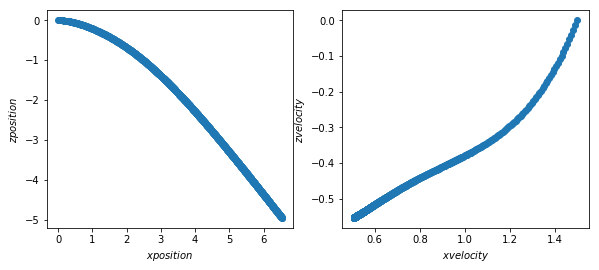

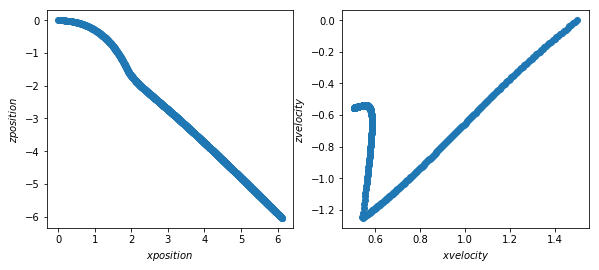

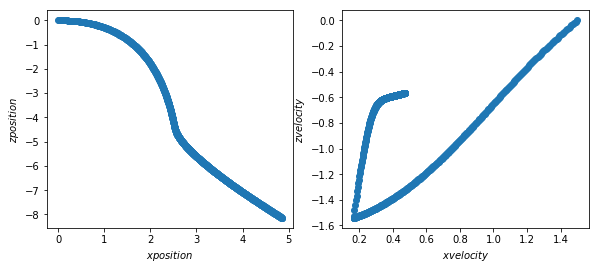

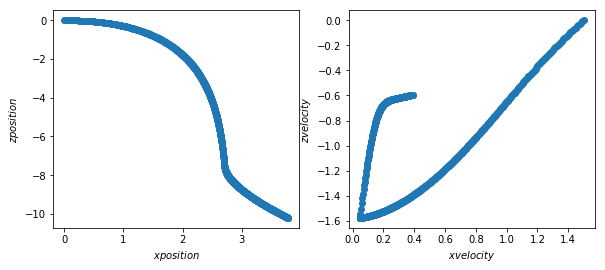

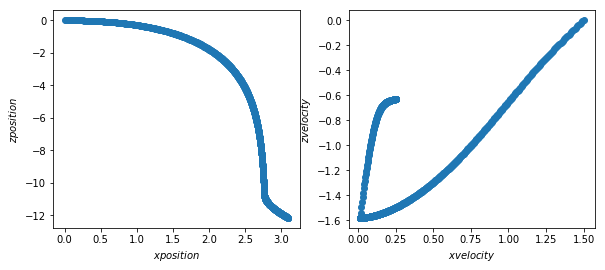

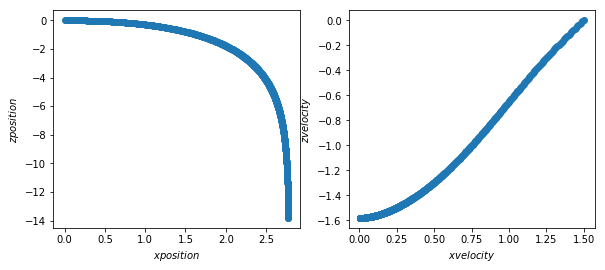

In [5]:
for q in range (1, w):
  plt.figure(figsize=(15, 4))

  #position graph

  plt.subplot(131)
  #plt.xlim(0,6)
  #plt.ylim(-6,0)
  plt.xlabel('$x position$')
  plt.ylabel('$z position$')
  plt.plot(valdict["xpos{0}".format(q)], valdict["ypos{0}".format(q)], 'o')
    
  #velocity graph  

  plt.subplot(132)
  plt.xlabel('$x velocity$')
  plt.ylabel('$z velocity$')
  plt.plot(valdict["xvel{0}".format(q)], valdict["yvel{0}".format(q)], 'o-')

### Plot velocity with time graph

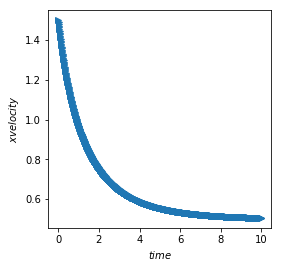

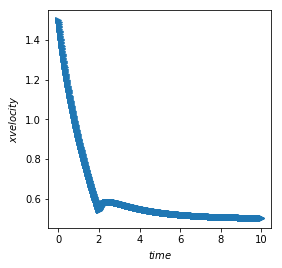

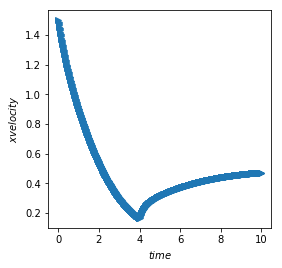

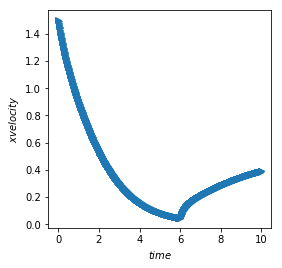

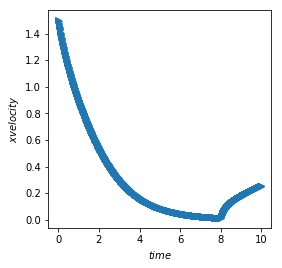

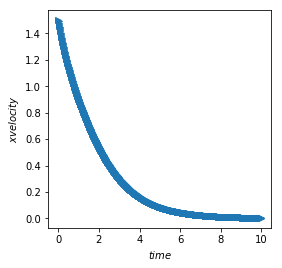

In [9]:
for q in range (1, w):
  plt.figure(figsize=(4, 4))
  plt.xlabel('$time$')
  plt.ylabel('$x velocity$')
  plt.plot(np.linspace(0, 10, 1000), valdict["xvel{0}".format(q)], '->') 

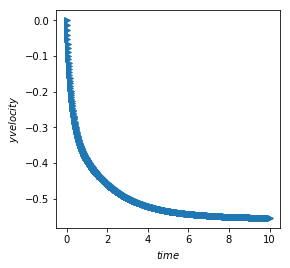

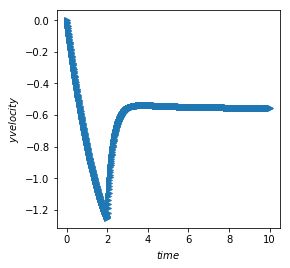

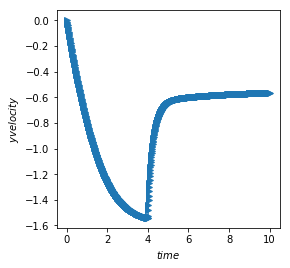

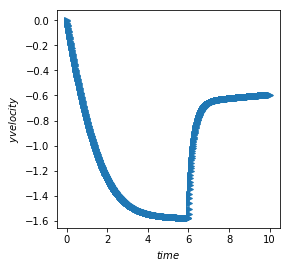

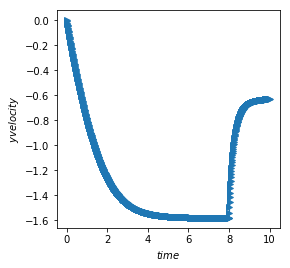

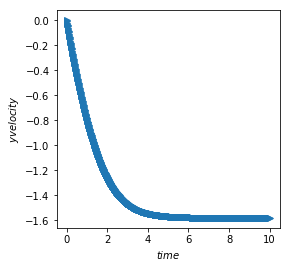

In [10]:
for q in range (1, w):
  plt.figure(figsize=(4, 4))
  plt.xlabel('$time$')
  plt.ylabel('$y velocity$')
  plt.plot(np.linspace(0, 10, 1000), valdict["yvel{0}".format(q)], '->') 

### Plot maximum x positions and velocities reached

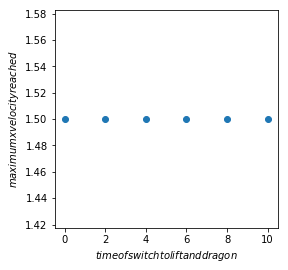

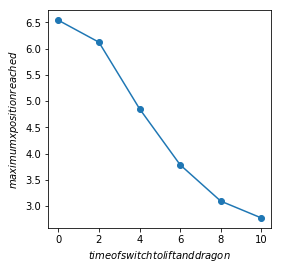

In [7]:
plt.figure(figsize=(4, 4))
plt.xlabel('$time of switch to lift and drag on$')
plt.ylabel('$maximum x velocity reached$')
plt.plot(timeofswitch, Xvelmax, 'o')

plt.figure(figsize=(4, 4))
plt.xlabel('$time of switch to lift and drag on$')
plt.ylabel('$maximum x position reached$')
plt.plot(timeofswitch, Xposmax, 'o-')

## Visually Simulate in VPython

In [8]:
from vpython import *                   ## visual python

trajectorynumber=3

scene= canvas(title='Glider Video', width=200, height=200, background=vector(0.5, 0.5, 0.5))
glider = sphere(pos=vector(-50, 50, 0), color = color.green, radius = 2.5, make_trail=True, retain=2000)
n=0
while n < len(valdict["xpos1"]):
    glider.pos=vector(valdict["xpos{0}".format(trajectorynumber)][n]-50, valdict["ypos{0}".format(trajectorynumber)][n]+50,0)
    n=n+1
    sleep(.0001)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>